In [81]:
# Automatically reload modules after executing each cell.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
import tensorflow as tf
from scipy import stats
import numpy as np
import sklearn.metrics as metrics

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=10)        #22
rc('xtick', labelsize=8)  #15
rc('ytick', labelsize=8)  #15
rc('legend', fontsize=8)  #15
rc('text.latex', preamble=r'\usepackage{amsmath}')

# Plots have dimension (w,h)
w = 3.5
h = 3.25       

from flows import *

import sys
import os

sys.path.append('../')
from utils.training import *
from utils.losses import *

np.random.seed(666)

In [83]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [88]:
mc = np.load("../data/zenodo/Pythia21_Zjet_pTZ-200GeV_0.npz")

sim_pt = mc['sim_jets'][:, 0]
sim_eta = mc['sim_jets'][:, 1]
sim_phi = mc['sim_jets'][:, 2]
sim_m = mc['sim_jets'][:, 3]
sim_mults = mc['sim_mults']
sim_lhas = mc['sim_lhas']
sim_widths = mc['sim_widths']
sim_ang2s = mc['sim_ang2s']
sim_tau2s = mc['sim_tau2s']
sim_sdms = mc['sim_sdms']
sim_zgs = mc['sim_zgs']

sim = np.vstack([sim_pt, sim_eta, sim_phi, sim_m]).T

In [31]:
dat = np.load("../data/zenodo/Herwig_Zjet_pTZ-200GeV_0.npz")

dat_pt =  dat['sim_jets'][:, 0] # dat[:, 0]
dat_eta = dat['sim_jets'][:, 1]
dat_phi = dat['sim_jets'][:, 2]
dat_m =   dat['sim_jets'][:, 3]

dat = np.vstack([dat_pt, dat_eta, dat_phi, dat_m]).T

In [32]:
n, d = dat.shape

# Load Flows

In [33]:
dat_target = make_target(d)
sim_target = make_target(d)

dat_ckpt = tf.train.Checkpoint(dat_target)
sim_ckpt = tf.train.Checkpoint(sim_target)

In [35]:
dat_ckpt.restore('dat6/ckpt-227')
sim_ckpt.restore('sim3/ckpt-235')

In [36]:
dat_smp = dat_target.sample(n)
sim_smp = sim_target.sample(n)

# Histograms

In [37]:
def ratio_hist(truth, fit,
               labels,
               color = "gray",
               figsize = (8, 8),
               x_lim = None,
               y_lim = None,
               title = None,
               filename = None):
    fig, axs = plt.subplots(2, 1,
                            figsize = figsize,
                            sharex = True, 
                            gridspec_kw = {'height_ratios': [2, 1]})
    
    truth = truth[(truth > x_lim[0]) & (truth < x_lim[1])]
    fit = fit[(fit > x_lim[0]) & (fit < x_lim[1])]
    
    t_hist = axs[0].hist(truth, bins = 50, density = True, color = color, alpha = 0.25, label = labels[0])
    f_hist = axs[0].hist(fit, bins = 50, density = True, histtype = 'step', color = 'red', label = labels[1])
    
    axs[0].minorticks_on()
    axs[0].tick_params(direction='in', which='both')
    axs[0].legend()
    
    if y_lim:
        axs[0].set_ylim(y_lim[0], y_lim[1])
    if x_lim:
        axs[0].set_xlim(x_lim[0], x_lim[1])
    
    bins = (f_hist[1] + np.diff(f_hist[1]).mean() / 2)[:-1]
    axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)
    axs[1].axhline(1,color="gray", lw=0.5)
    
    axs[1].minorticks_on()
    axs[1].tick_params(direction='in', which='both')
    axs[1].set_ylim(0, 2)
    
    plt.xlabel(labels[2])
    
    if title:
        axs[0].set_title(title, loc = "right")
    if filename:
        plt.savefig(filename, 
                    dpi = 300,
                    transparent = True,
                    bbox_inches = 'tight')

## Data

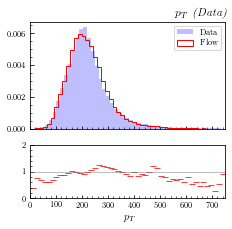

In [38]:
ratio_hist(dat[:, 0], dat_smp[:, 0], 
           labels = ['Data', 'Flow', r'$p_T$'],
           color = 'blue',
           figsize = (w, h),
           title = r'\it $p_T$ (Data)',
           x_lim = (0, 750),
           filename = '../plots/zenodo/flows/dat6/pT_data.png'
          )

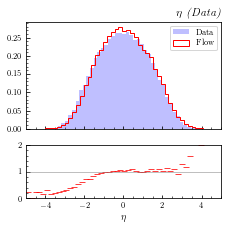

In [39]:
ratio_hist(dat[:, 1], dat_smp[:, 1], 
           labels = ['Data', 'Flow', r'$\eta$'],
           color = 'blue',
           figsize = (w, h),
           title = r'\it $\eta$ (Data)',
           x_lim = (-5, 5),
           filename = '../plots/zenodo/flows/dat6/eta_data.png'
          )

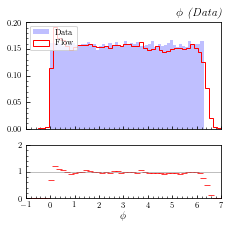

In [40]:
ratio_hist(dat[:, 2], dat_smp[:, 2], 
           labels = ['Data', 'Flow', r'$\phi$'],
           color = 'blue',
           figsize = (w, h),
           title = r'\it $\phi$ (Data)',
           x_lim = (-1, 7),
           filename = '../plots/zenodo/flows/dat6/phi_data.png'
          )

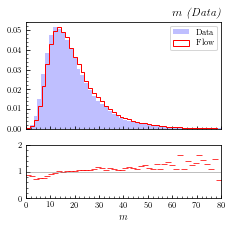

In [41]:
ratio_hist(dat[:, 3], dat_smp[:, 3], 
           labels = ['Data', 'Flow', r'$m$'],
           color = 'blue',
           figsize = (w, h),
           title = r'\it $m$ (Data)',
           x_lim = (0, 80),
           filename = '../plots/zenodo/flows/dat6/m_data.png'
          )

## MC

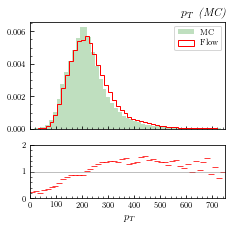

In [42]:
ratio_hist(sim[:, 0], sim_smp[:, 0], 
           labels = ['MC', 'Flow', r'$p_T$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $p_T$ (MC)',
           x_lim = (0, 750),
           filename = '../plots/zenodo/flows/sim3/pT_mc.png'
          )

/tmp/ipykernel_18641/4039115727.py:30: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


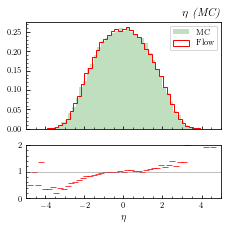

In [43]:
ratio_hist(sim[:, 1], sim_smp[:, 1], 
           labels = ['MC', 'Flow', r'$\eta$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $\eta$ (MC)',
           x_lim = (-5, 5),
           filename = '../plots/zenodo/flows/sim3/eta_mc.png'
          )

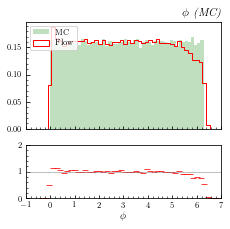

In [44]:
ratio_hist(sim[:, 2], sim_smp[:, 2], 
           labels = ['MC', 'Flow', r'$\phi$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $\phi$ (MC)',
           x_lim = (-1, 7),
           filename = '../plots/zenodo/flows/sim3/phi_mc.png'
          )

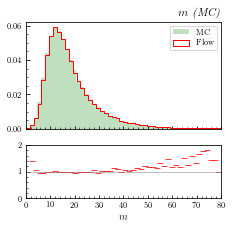

In [45]:
ratio_hist(sim[:, 3], sim_smp[:, 3], 
           labels = ['MC', 'Flow', r'$m$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $m$ (MC)',
           x_lim = (0, 80),
           filename = '../plots/zenodo/flows/sim3/m_mc.png'
          )

# Classification

## MC

In [46]:
X_bkgd = sim_smp
X_sgnl = sim

In [47]:
np.random.seed(666)

# Create full dataset; randomly sample points from Data or Flow with chance 1/2.
y = stats.bernoulli.rvs(0.5, size = n).astype('float32')
X = np.zeros_like(X_bkgd)

X[y == 0] = X_bkgd[y == 0]
X[y == 1] = X_sgnl[y == 1]

# Take 70% of data to be training data.
N_trn = int(0.7*n)
trn_idx = np.random.choice(range(n), N_trn, replace = False)
tst_idx = [n for n in range(n) if n not in trn_idx]

X_trn = X[trn_idx]
y_trn = y[trn_idx]

X_tst = X[tst_idx]
y_tst = y[tst_idx]

data, m, s = split_data(X_trn, y_trn)

In [48]:
from sklearn.ensemble import AdaBoostClassifier
ab_clf = AdaBoostClassifier()
ab_clf.fit(X_trn, y_trn)

AdaBoostClassifier()

In [49]:
y_hat = ab_clf.predict_proba(X_tst)[:, 1]
fpr, tpr, ts = metrics.roc_curve(y_tst, y_hat)
auc = metrics.roc_auc_score(y_tst, y_hat)

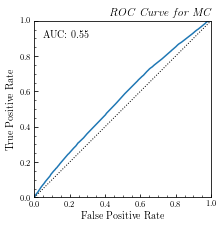

In [50]:
fig, ax = plt.subplots(figsize = (w, h))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, ls = ':', c = 'k', lw = 1)

plt.title('\it ROC Curve for MC', loc = 'right')
plt.text(0.05, 0.9, 'AUC: {}'.format(round(auc, 2)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.gca().minorticks_on()
plt.gca().tick_params(direction='in', which='both')
plt.gca().set_aspect('equal')

plt.savefig('../plots/zenodo/flows/sim3/mc_roc.png', dpi = 300, transparent = True,
            bbox_inches = 'tight')

## Data

In [51]:
X_bkgd = dat_smp
X_sgnl = dat

In [52]:
np.random.seed(666)

# Create full dataset; randomly sample points from Data or Flow with chance 1/2.
y = stats.bernoulli.rvs(0.5, size = n).astype('float32')
X = np.zeros_like(X_bkgd)

X[y == 0] = X_bkgd[y == 0]
X[y == 1] = X_sgnl[y == 1]

# Take 70% of data to be training data.
N_trn = int(0.7*n)
trn_idx = np.random.choice(range(n), N_trn, replace = False)
tst_idx = [n for n in range(n) if n not in trn_idx]

X_trn = X[trn_idx]
y_trn = y[trn_idx]

X_tst = X[tst_idx]
y_tst = y[tst_idx]

data, m, s = split_data(X_trn, y_trn)

In [53]:
from sklearn.ensemble import AdaBoostClassifier
ab_clf = AdaBoostClassifier()
ab_clf.fit(X_trn, y_trn)

AdaBoostClassifier()

In [54]:
y_hat = ab_clf.predict_proba(X_tst)[:, 1]
fpr, tpr, ts = metrics.roc_curve(y_tst, y_hat)
auc = metrics.roc_auc_score(y_tst, y_hat)

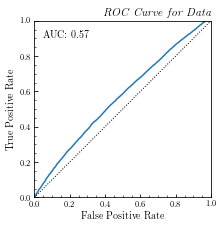

In [55]:
fig, ax = plt.subplots(figsize = (w, h))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, ls = ':', c = 'k', lw = 1)

plt.title('\it ROC Curve for Data', loc = 'right')
plt.text(0.05, 0.9, 'AUC: {}'.format(round(auc, 2)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.gca().minorticks_on()
plt.gca().tick_params(direction='in', which='both')
plt.gca().set_aspect('equal')

plt.savefig('../plots/zenodo/flows/dat6/data_roc.png', dpi = 300, transparent = True,
            bbox_inches = 'tight')

## Undertraining and Overtraining

In [78]:
ks = np.arange(5, 236, 5)

aucs = np.zeros(len(ks))
for i in range(len(ks)):
    k = ks[i]
    print(k, end = ' ')
    dat_target = make_target(d)
    dat_ckpt = tf.train.Checkpoint(dat_target)
    dat_ckpt.restore('dat6/ckpt-{}'.format(k))
    dat_smp = dat_target.sample(n)

    X_bkgd = dat_smp
    X_sgnl = dat

    # Create full dataset; randomly sample points from Data or Flow with chance 1/2.
    y = stats.bernoulli.rvs(0.5, size = n).astype('float32')
    X = np.zeros_like(X_bkgd)

    X[y == 0] = X_bkgd[y == 0]
    X[y == 1] = X_sgnl[y == 1]

    # Take 70% of data to be training data.
    N_trn = int(0.7*n)
    trn_idx = np.random.choice(range(n), N_trn, replace = False)
    tst_idx = [n for n in range(n) if n not in trn_idx]

    X_trn = X[trn_idx]
    y_trn = y[trn_idx]

    X_tst = X[tst_idx]
    y_tst = y[tst_idx]

    data, m, s = split_data(X_trn, y_trn)
    
    reps = 100
    avg = [None] * reps
    for j in range(reps):
        print(j, end = ' ')
        ab_clf = AdaBoostClassifier()
        ab_clf.fit(X_trn, y_trn)

        y_hat = ab_clf.predict_proba(X_tst)[:, 1]
        avg[j] = metrics.roc_auc_score(y_tst, y_hat) 
    aucs[i] = np.mean(avg)
    print(np.round(aucs[i], 3))

5 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 0.968
10 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 0.74
15 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 0.628
20 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 3

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [79]:
aucs

array([0.96804062, 0.74046023, 0.62759672, 0.57427276, 0.5609962 ,
       0.54127759, 0.55605298, 0.55914435, 0.58676614, 0.53399094,
       0.54621149, 0.56087443, 0.53314748, 0.57147421, 0.54081062,
       0.53982104, 0.54754919, 0.56814949, 0.55157966, 0.53958954,
       0.54913091, 0.56161732, 0.5287634 , 0.54110753, 0.54430936,
       0.56101893, 0.55943821, 0.5460614 , 0.5568134 , 0.54073152,
       0.56699364, 0.54828628, 0.551818  , 0.54529789, 0.56969678,
       0.55940512, 0.54876799, 0.57102909, 0.57568781, 0.54719827,
       0.55362283, 0.54575717, 0.54994713, 0.54136782, 0.55334008,
       0.54170949, 0.54063925])

(0.5, 0.6)

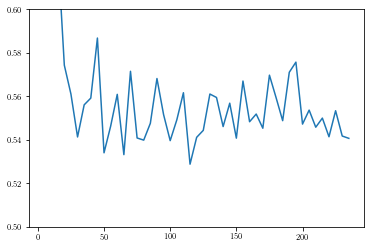

In [80]:
plt.plot(ks, aucs)
plt.ylim(0.5, 0.6)